# Topic Modeling (Prepare)

On Monday we talked about summarizing your documents using just token counts. Today, we're going to learn about a much more sophisticated approach - learning 'topics' from documents. Topics are a latent structure. They are not directly observable in the data, but we know they're there by reading them.

> **latent**: existing but not yet developed or manifest; hidden or concealed.

## Use Cases
Primary use case: what the hell are your documents about? Who might want to know that in industry - 
* Identifying common themes in customer reviews
* Discovering the needle in a haystack 
* Monitoring communications (Email - State Department) 

## Learning Objectives
*At the end of the lesson you should be able to:*
* Part 0: Warm-Up
* Part 1: Describe how an LDA Model works
* Part 2: Estimate a LDA Model with Gensim
* Part 3: Interpret LDA results & Select the appropriate number of topics

# Part 0: Warm-Up
How do we do a grid search? 

In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
import pandas as pd
from sklearn.datasets import fetch_20newsgroups
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer

In [3]:
# Dataset
categories = ['sci.electronics',
              'rec.sport.baseball',
              'rec.sport.hockey']

# Load training data
newsgroups_train = fetch_20newsgroups(subset='train', 
                                      remove=('headers', 'footers', 'quotes'),
                                      categories=categories)

# Load testing data
newsgroups_test = fetch_20newsgroups(subset='test', 
                                     remove=('headers', 'footers', 'quotes'),
                                     categories=categories)

print(f'Training Samples: {len(newsgroups_train.data)}')
print(f'Testing Samples: {len(newsgroups_test.data)}')

Training Samples: 1788
Testing Samples: 1189


In [4]:
newsgroups_train.keys()

dict_keys(['data', 'filenames', 'target_names', 'target', 'DESCR'])

In [5]:
newsgroups_train['target_names']

['rec.sport.baseball', 'rec.sport.hockey', 'sci.electronics']

In [6]:
newsgroups_train['data'][10]

"\n\n\nI would have chosen Alex Zhitnik for biggest suprise.  They\ndid expect that he would become a great defenseman, but I don't\nthink anyone knew that he was going to be this impressive in his \nrookie year.  His speed, skating ability, and puck control is\nexceptional -- he is the one to watch on the Kings.\n\n\nKris\nkris@fs2.assist.uci.edu\n\nGO KINGS!\n"

### GridSearch on Just Classifier
* Fit the vectorizer and prepare BEFORE it goes into the gridsearch

In [7]:
v1 = TfidfVectorizer(stop_words='english',
                     min_df=5)
X_train = v1.fit_transform(newsgroups_train['data'])
print(X_train.shape)

(1788, 3984)


In [8]:
p1 = {
    'n_estimators': [10, 20],
    'max_depth': [None, 7]
}

In [9]:
clf = RandomForestClassifier()
gs1 = GridSearchCV(clf, p1, cv=5,n_jobs=-1, verbose=1)
gs1.fit(X_train, newsgroups_train['target'])

Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:    4.1s finished


GridSearchCV(cv=5, estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'max_depth': [None, 7], 'n_estimators': [10, 20]},
             verbose=1)

In [10]:
gs1.cv_results_

{'mean_fit_time': array([0.20870953, 0.3253469 , 0.06950517, 0.11479745]),
 'std_fit_time': array([0.01210044, 0.03769352, 0.00613556, 0.00537914]),
 'mean_score_time': array([0.00859885, 0.00892434, 0.00680361, 0.02019897]),
 'std_score_time': array([0.00206193, 0.00730515, 0.00039989, 0.00790797]),
 'param_max_depth': masked_array(data=[None, None, 7, 7],
              mask=[False, False, False, False],
        fill_value='?',
             dtype=object),
 'param_n_estimators': masked_array(data=[10, 20, 10, 20],
              mask=[False, False, False, False],
        fill_value='?',
             dtype=object),
 'params': [{'max_depth': None, 'n_estimators': 10},
  {'max_depth': None, 'n_estimators': 20},
  {'max_depth': 7, 'n_estimators': 10},
  {'max_depth': 7, 'n_estimators': 20}],
 'split0_test_score': array([0.77374302, 0.78212291, 0.65642458, 0.73184358]),
 'split1_test_score': array([0.81843575, 0.82960894, 0.70391061, 0.76256983]),
 'split2_test_score': array([0.80167598, 0.8

In [11]:
gs1.best_score_

0.8283179193465096

In [12]:
gs1.best_params_

{'max_depth': None, 'n_estimators': 20}

In [13]:
# gs1.predict(["The new york yankees are the best team in baseball"])

In [14]:
test_sample = v1.transform(["The new york yankees are the best team in baseball"])
test_sample.shape

(1, 3984)

In [15]:
test_sample

<1x3984 sparse matrix of type '<class 'numpy.float64'>'
	with 6 stored elements in Compressed Sparse Row format>

In [16]:
print(test_sample)

  (0, 3967)	0.48550433292273737
  (0, 3957)	0.5275426830191695
  (0, 3574)	0.2916145216048335
  (0, 2458)	0.34588673174686463
  (0, 636)	0.3613707509629898
  (0, 583)	0.38822516693960607


In [17]:
v1.get_feature_names()[1111]

'da'

In [18]:
pred = gs1.predict(test_sample)
pred

array([0], dtype=int64)

In [19]:
newsgroups_train['target_names'][pred[0]]

'rec.sport.baseball'

### GridSearch with BOTH the Vectoizer & Classifier

In [20]:
from sklearn.pipeline import Pipeline

# 1. Create a pipeline with a vectorize and a classifier
# 2. Use Grid Search to optimize the entire pipeline
pipeline = Pipeline([
    ('vect', TfidfVectorizer()),
    ('clf', RandomForestClassifier())
])

p2 = {
    'vect__stop_words': (None, 'english'),
#     'vect__tokenizer': (can use the standard=None, or put in others)
    'vect__min_df': (2, 5),
    'clf__max_depth': (7, None)
}

gs2 = GridSearchCV(pipeline, p2, cv=5, n_jobs=-2, verbose=1)
gs2.fit(newsgroups_train['data'], newsgroups_train['target'])

Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=-2)]: Done  40 out of  40 | elapsed:   24.9s finished


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('vect', TfidfVectorizer()),
                                       ('clf', RandomForestClassifier())]),
             n_jobs=-2,
             param_grid={'clf__max_depth': (7, None), 'vect__min_df': (2, 5),
                         'vect__stop_words': (None, 'english')},
             verbose=1)

In [21]:
gs2.best_score_

0.8506908908814923

In [22]:
gs2.best_params_

{'clf__max_depth': None, 'vect__min_df': 2, 'vect__stop_words': 'english'}

In [23]:
pred = gs2.predict(["The new york yankees are the best team in baseball"])
pred

array([0], dtype=int64)

In [24]:
newsgroups_train['target_names'][pred[0]]

'rec.sport.baseball'

Advantages to using GS with the Pipe:
* Allows us to make predictions on raw text increasing reproducibility. :)
* Allows us to tune the parameters of the vectorizer along side the classifier. :D 

# Part 1: Describe how an LDA Model works

[Your Guide to Latent Dirichlet Allocation](https://medium.com/@lettier/how-does-lda-work-ill-explain-using-emoji-108abf40fa7d)

[LDA Topic Modeling](https://lettier.com/projects/lda-topic-modeling/)

[Topic Modeling with Gensim](https://www.machinelearningplus.com/nlp/topic-modeling-gensim-python/)

In [25]:
# Download spacy model
import spacy.cli
spacy.cli.download("en_core_web_lg")

✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_lg')


In [26]:
import re
import numpy as np
import pandas as pd
from pprint import pprint

import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

import spacy

import pyLDAvis
import pyLDAvis.gensim 
import matplotlib.pyplot as plt
%matplotlib inline

In [27]:
df = pd.DataFrame({
    'content': newsgroups_train['data'],
    'target': newsgroups_train['target'],
    'target_names': [newsgroups_train['target_names'][i] for i in newsgroups_train['target']]
})
print(df.shape)
df.head(3)

(1788, 3)


C:\Users\whats\anaconda3\envs\U4-S1-NLP\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,content,target,target_names
0,"\nOh yeah, how come Dino could never take the ...",1,rec.sport.hockey
1,Does anyone know where Billy Taylor is? Richm...,0,rec.sport.baseball
2,\n\n\nWhy are you fooling around with analog f...,2,sci.electronics


In [28]:
# For reference on regex: https://docs.python.org/3/library/re.html
# 1. Remove new line characters
df['clean_text'] = df['content'].apply(lambda x: re.sub('\s+', ' ', x))

# 2. Remove Emails
df['clean_text'] = df['clean_text'].apply(lambda x: re.sub('From: \S+@\S+', '', x))

# 3. Remove non-alphanumeric characters
df['clean_text'] = df['clean_text'].apply(lambda x: re.sub('[^a-zA-Z]', ' ', x))

# 4. Remove extra whitespace and lowercase text
df['clean_text'] = df['clean_text'].apply(lambda x: ' '.join(x.lower().split()))


C:\Users\whats\anaconda3\envs\U4-S1-NLP\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
<>:3: DeprecationWarning: invalid escape sequence \s
<>:6: DeprecationWarning: invalid escape sequence \S
<>:3: DeprecationWarning: invalid escape sequence \s
<>:6: DeprecationWarning: invalid escape sequence \S
<ipython-input-28-f5246db7dc36>:3: DeprecationWarning: invalid escape sequence \s
  df['clean_text'] = df['content'].apply(lambda x: re.sub('\s+', ' ', x))
<ipython-input-28-f5246db7dc36>:6: DeprecationWarning: invalid escape sequence \S
  df['clean_text'] = df['clean_text'].apply(lambda x: re.sub('From: \S+@\S+', '', x))


In [29]:
pd.set_option('display.max_colwidth',300)
df.sample(3)

C:\Users\whats\anaconda3\envs\U4-S1-NLP\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,content,target,target_names,clean_text
1322,"Hi,\n\n I've just built a valve preamp and use a diode/capacitor\nvoltage multiplier to step the 12vAC supply voltage up to approx \n260vDV. As the load resistance increases, the RC constant decreases\nand hence the output voltage drops. I need as high an output\nvoltage as possible. (about 26...",2,sci.electronics,hi i ve just built a valve preamp and use a diode capacitor voltage multiplier to step the vac supply voltage up to approx vdv as the load resistance increases the rc constant decreases and hence the output voltage drops i need as high an output voltage as possible about v the circuit consists o...
870,"I hope that this comes off as a somewhat unbiased assesment\nof WFAN and WIP(I go to school in Philadelphia, and I listen to\nboth stations on a consistant basis.) Now that the fan has Mike\nLupica on from 10 to noon, they have a person who can get the \nbig name guests for interviews, and not ...",0,rec.sport.baseball,i hope that this comes off as a somewhat unbiased assesment of wfan and wip i go to school in philadelphia and i listen to both stations on a consistant basis now that the fan has mike lupica on from to noon they have a person who can get the big name guests for interviews and not just of local ...
1345,"Well, as long as folks are sharing their esteemed wisdom, Li'l Karnak sez:\n\n\tAL West\t\tAL East \tNL West\t\tNL East \n\t1) Chicago\t1) Toronto\t1) Atlanta\t1) St. Louis\n\t2) Texas\t2) New York\t2) Cincinnati\t2) Montreal \n\t3) Minnesota\t3) Baltimore\t3) Houston\t3) New York \n\t4) Oakland...",0,rec.sport.baseball,well as long as folks are sharing their esteemed wisdom li l karnak sez al west al east nl west nl east chicago toronto atlanta st louis texas new york cincinnati montreal minnesota baltimore houston new york oakland boston los angeles philadelphia seattle detroit san diego pittsburgh kansas cit...


In [30]:
# # # FOR MAC OR LINIX
# # from pandarallel import pandarallel
# # pandarallel.initialize(progress_bar=True)
# # speeds up processing


# # Leverage tqdm for progress_apply
# from tqdm import tqdm
# tqdm.pandas()
# # If you're on macOS, Linux, or python session executed from Windows Subsystem for Linux (WSL)
# # conda activate U4-S1-NLP
# # pip install pandarallel
# #
# # from pandarallel import pandarallel
# # pandarallel.initialize(progress_bar=True)
# #
# # df['lemmas'] = df['content'].parallel_apply(get_lemmas)
# #
# # Ref: https://github.com/nalepae/pandarallel

C:\Users\whats\anaconda3\envs\U4-S1-NLP\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [31]:
nlp = spacy.load("en_core_web_lg", disable=['parser', 'tagger', 'ner'])

C:\Users\whats\anaconda3\envs\U4-S1-NLP\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [32]:
# # Leverage tqdm for progress_apply
from tqdm import tqdm
tqdm.pandas()
# Create 'lemmas' column
def get_lemmas(x):
    lemmas = []
    for token in nlp(x):
        if (token.is_stop != True) and (token.is_punct != True) and (len(token) > 2):
            lemmas.append(token.lemma_)
    return lemmas
df['lemmas'] = df['clean_text'].progress_apply(get_lemmas)
df.head(3)

C:\Users\whats\anaconda3\envs\U4-S1-NLP\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
100%|█████████████████████████████████████████████████████████████████████████████| 1788/1788 [00:03<00:00, 465.73it/s]


,content,target,target_names,clean_text,lemmas
0,"\nOh yeah, how come Dino could never take the Caps out of the Patrick\nDivision? He choked up 3 games to 1 last year and got swept away in\nthe second round two years ago. He rarely, if ever, makes it out of the\ndivision.\n\n\nSo are the Islanders, but they can still pull it out. Vancouver h...",1,rec.sport.hockey,oh yeah how come dino could never take the caps out of the patrick division he choked up games to last year and got swept away in the second round two years ago he rarely if ever makes it out of the division so are the islanders but they can still pull it out vancouver has winnipeg s number so i...,"[yes, come, dino, cap, patrick, division, choke, game, year, get, sweep, away, 2, round, year, ago, rarely, make, division, islander, pull, vancouver, winnipeg, numb, doesn, matt, king, play, game, difference, battle, pull, calgary, pull]"
1,"Does anyone know where Billy Taylor is? Richmond or Syracuse? He was taken\nby the Jays in the Rule V draft, but not kept on the roster. Baseball Weekly\nsaid that he was demoted to Syracuse, but a Toronto paper indicated that\nthe Braves took him back. Is there an Atlanta fan, or anyone rea...",0,rec.sport.baseball,does anyone know where billy taylor is richmond or syracuse he was taken by the jays in the rule v draft but not kept on the roster baseball weekly said that he was demoted to syracuse but a toronto paper indicated that the braves took him back is there an atlanta fan or anyone reading this who ...,"[know, billy, taylor, richmond, syracuse, take, jay, rule, draft, keep, roster, baseball, weekly, say, demote, syracuse, toronto, paper, indicate, brave, take, atlanta, fan, read, know]"
2,"\n\n\nWhy are you fooling around with analog for this job? A single chip\nmicro and a crystal will do the job reliably and easily. An 8748 only\ncosts about $5. That and a $1 crystal and you're in business. Embed\nthe whole thing in a foam insulated blanket, power it from a solar cell,\nuse ...",2,sci.electronics,why are you fooling around with analog for this job a single chip micro and a crystal will do the job reliably and easily an only costs about that and a crystal and you re in business embed the whole thing in a foam insulated blanket power it from a solar cell use the excess power to heat the as...,"[fool, analog, job, single, chip, micro, crystal, job, reliably, easily, cost, crystal, business, embed, thing, foam, insulate, blanket, power, solar, cell, use, excess, power, heat, assembly, day, rely, insulation, hold, heat, darkness, don, want, try, thermal, management, contact, like, icl, c..."


### The two main inputs to the LDA topic model are the dictionary (id2word) and the corpus.

In [33]:
# Create Dictionary
id2word = corpora.Dictionary(df['lemmas'])

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in df['lemmas']]

C:\Users\whats\anaconda3\envs\U4-S1-NLP\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [34]:
# How many words in our vocab?
len(id2word.keys())

C:\Users\whats\anaconda3\envs\U4-S1-NLP\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


12626

In [35]:
id2word[200]

C:\Users\whats\anaconda3\envs\U4-S1-NLP\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


'trade'

In [36]:
df['clean_text'][5]

C:\Users\whats\anaconda3\envs\U4-S1-NLP\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


'ok i m sure that this has been asked s of times before but i have wondered since i heard it where the hell did the nickname of the habs come from for the montreal canadiens'

In [37]:
corpus[5]

C:\Users\whats\anaconda3\envs\U4-S1-NLP\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


[(7, 1),
 (183, 1),
 (192, 1),
 (202, 1),
 (203, 1),
 (204, 1),
 (205, 1),
 (206, 1),
 (207, 1),
 (208, 1),
 (209, 1)]

In [38]:
id2word[252]

C:\Users\whats\anaconda3\envs\U4-S1-NLP\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


'francisco'

In [39]:
id2word[276]

C:\Users\whats\anaconda3\envs\U4-S1-NLP\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


'new'

In [40]:
# Human readable format of corpus (term-frequency)
[(id2word[word_id], word_count) for word_id, word_count in corpus[5]]

C:\Users\whats\anaconda3\envs\U4-S1-NLP\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


[('come', 1),
 ('time', 1),
 ('hell', 1),
 ('ask', 1),
 ('canadiens', 1),
 ('habs', 1),
 ('hear', 1),
 ('montreal', 1),
 ('nickname', 1),
 ('sure', 1),
 ('wonder', 1)]

# Part 2: Estimate a LDA Model with Gensim

 ### Train an LDA model

In [41]:
# %%time
# lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
#                                            id2word=id2word,
#                                            num_topics=20, 
#                                            chunksize=100,
#                                            passes=10,
#                                            per_word_topics=True)

# # https://radimrehurek.com/gensim/models/ldamodel.html

C:\Users\whats\anaconda3\envs\U4-S1-NLP\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [42]:
# lda_model.save('lda_model.model')

C:\Users\whats\anaconda3\envs\U4-S1-NLP\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [43]:
%%time
lda_multicore = gensim.models.ldamulticore.LdaMulticore(corpus=corpus,
                                                        id2word=id2word,
                                                        num_topics=20, 
                                                        chunksize=100,
                                                        passes=10,
                                                        per_word_topics=True,
                                                        workers=3)

# https://radimrehurek.com/gensim/models/ldamulticore.html

C:\Users\whats\anaconda3\envs\U4-S1-NLP\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Wall time: 2min 24s


In [44]:
#below is essentially the same as pickling
lda_multicore.save('lda_multicore.model')

C:\Users\whats\anaconda3\envs\U4-S1-NLP\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [45]:
from gensim import models
lda_multicore =  models.LdaModel.load('lda_multicore.model')

C:\Users\whats\anaconda3\envs\U4-S1-NLP\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


### View the topics in LDA model

In [46]:
pprint(lda_multicore.print_topics())


[(0,
  '0.014*"use" + 0.013*"work" + 0.011*"need" + 0.010*"like" + 0.010*"know" + '
  '0.010*"power" + 0.008*"circuit" + 0.008*"high" + 0.008*"line" + '
  '0.008*"chip"'),
 (1,
  '0.014*"cable" + 0.011*"day" + 0.009*"connect" + 0.008*"don" + 0.008*"metal" '
  '+ 0.008*"use" + 0.008*"information" + 0.007*"strip" + 0.007*"thank" + '
  '0.007*"read"'),
 (2,
  '0.013*"protection" + 0.011*"stadium" + 0.009*"bus" + 0.009*"uniform" + '
  '0.008*"edu" + 0.007*"change" + 0.007*"old" + 0.007*"foul" + '
  '0.007*"properly" + 0.007*"cable"'),
 (3,
  '0.024*"team" + 0.016*"hockey" + 0.016*"nhl" + 0.012*"season" + 0.010*"game" '
  '+ 0.010*"league" + 0.008*"new" + 0.008*"draft" + 0.008*"player" + '
  '0.007*"play"'),
 (4,
  '0.023*"year" + 0.018*"team" + 0.017*"run" + 0.016*"well" + 0.015*"win" + '
  '0.013*"player" + 0.012*"game" + 0.012*"pitch" + 0.012*"think" + '
  '0.012*"good"'),
 (5,
  '0.021*"play" + 0.020*"goal" + 0.016*"flyer" + 0.015*"game" + 0.014*"puck" + '
  '0.012*"shoot" + 0.012*"pena

C:\Users\whats\anaconda3\envs\U4-S1-NLP\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [47]:
doc_lda = lda_multicore[corpus]
doc_lda[1][0]

C:\Users\whats\anaconda3\envs\U4-S1-NLP\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


[(1, 0.060072396), (6, 0.7057504), (17, 0.0776221), (18, 0.12575416)]

In [48]:
df.head(2)

C:\Users\whats\anaconda3\envs\U4-S1-NLP\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,content,target,target_names,clean_text,lemmas
0,"\nOh yeah, how come Dino could never take the Caps out of the Patrick\nDivision? He choked up 3 games to 1 last year and got swept away in\nthe second round two years ago. He rarely, if ever, makes it out of the\ndivision.\n\n\nSo are the Islanders, but they can still pull it out. Vancouver h...",1,rec.sport.hockey,oh yeah how come dino could never take the caps out of the patrick division he choked up games to last year and got swept away in the second round two years ago he rarely if ever makes it out of the division so are the islanders but they can still pull it out vancouver has winnipeg s number so i...,"[yes, come, dino, cap, patrick, division, choke, game, year, get, sweep, away, 2, round, year, ago, rarely, make, division, islander, pull, vancouver, winnipeg, numb, doesn, matt, king, play, game, difference, battle, pull, calgary, pull]"
1,"Does anyone know where Billy Taylor is? Richmond or Syracuse? He was taken\nby the Jays in the Rule V draft, but not kept on the roster. Baseball Weekly\nsaid that he was demoted to Syracuse, but a Toronto paper indicated that\nthe Braves took him back. Is there an Atlanta fan, or anyone rea...",0,rec.sport.baseball,does anyone know where billy taylor is richmond or syracuse he was taken by the jays in the rule v draft but not kept on the roster baseball weekly said that he was demoted to syracuse but a toronto paper indicated that the braves took him back is there an atlanta fan or anyone reading this who ...,"[know, billy, taylor, richmond, syracuse, take, jay, rule, draft, keep, roster, baseball, weekly, say, demote, syracuse, toronto, paper, indicate, brave, take, atlanta, fan, read, know]"


### What is topic Perplexity?
Perplexity is a statistical measure of how well a probability model predicts a sample. As applied to LDA, for a given value of , you estimate the LDA model. Then given the theoretical word distributions represented by the topics, compare that to the actual topic mixtures, or distribution of words in your documents.

### What is topic coherence?
Topic Coherence measures score a single topic by measuring the degree of semantic similarity between high scoring words in the topic. These measurements help distinguish between topics that are semantically interpretable topics and topics that are artifacts of statistical inference.
A set of statements or facts is said to be coherent, if they support each other. Thus, a coherent fact set can be interpreted in a context that covers all or most of the facts. An example of a coherent fact set is “the game is a team sport”, “the game is played with a ball”, “the game demands great physical efforts”

In [49]:
# Compute Perplexity
print('\nPerplexity: ', lda_multicore.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_multicore, 
                                     texts=df['lemmas'], 
                                     dictionary=id2word, 
                                     coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)

C:\Users\whats\anaconda3\envs\U4-S1-NLP\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)



Perplexity:  -9.288675657195762

Coherence Score:  0.5575641340926303


# Part 3: Interpret LDA results & Select the appropriate number of topics

In [50]:
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_multicore, corpus, id2word)
pyLDAvis.display(vis)

C:\Users\whats\anaconda3\envs\U4-S1-NLP\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [51]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.ldamulticore.LdaMulticore(corpus=corpus,
                                                        id2word=id2word,
                                                        num_topics=num_topics, 
                                                        chunksize=100,
                                                        passes=10,
                                                        per_word_topics=True,
                                                        workers=12)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

C:\Users\whats\anaconda3\envs\U4-S1-NLP\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [52]:
# %%time
# model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=df['lemmas'], start=2, limit=40, step=6)

C:\Users\whats\anaconda3\envs\U4-S1-NLP\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [53]:
coherence_values = [0.5054, 0.5332, 0.5452, 0.564, 0.5678, 0.5518, 0.519]

C:\Users\whats\anaconda3\envs\U4-S1-NLP\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


C:\Users\whats\anaconda3\envs\U4-S1-NLP\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


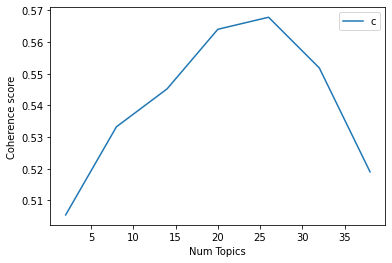

In [54]:
limit=40; start=2; step=6;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [55]:
# Print the coherence scores
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

Num Topics = 2  has Coherence Value of 0.5054
Num Topics = 8  has Coherence Value of 0.5332
Num Topics = 14  has Coherence Value of 0.5452
Num Topics = 20  has Coherence Value of 0.564
Num Topics = 26  has Coherence Value of 0.5678
Num Topics = 32  has Coherence Value of 0.5518
Num Topics = 38  has Coherence Value of 0.519


C:\Users\whats\anaconda3\envs\U4-S1-NLP\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [56]:
# Select the model and print the topics
#optimal_model = model_list[4]
optimal_model =  models.LdaModel.load('optimal_model.model')
model_topics = optimal_model.show_topics(formatted=False)
pprint(optimal_model.print_topics(num_words=10))

C:\Users\whats\anaconda3\envs\U4-S1-NLP\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


FileNotFoundError: [Errno 2] No such file or directory: 'optimal_model.model'